In [6]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, fancy_legend, load_mpl_presets
import numpy as np
import vice
import sys
load_mpl_presets()
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [8]:
output = vice.output("../outputs/inside-out/vrad0")
extra = np.genfromtxt("../outputs/inside-out/vrad0_analogdata.out")
output.stars["absz"] = [abs(_) for _ in extra[:,-1][:output.stars.size[0]]]
stars = output.stars.filter("absz", "<=", 0.5)

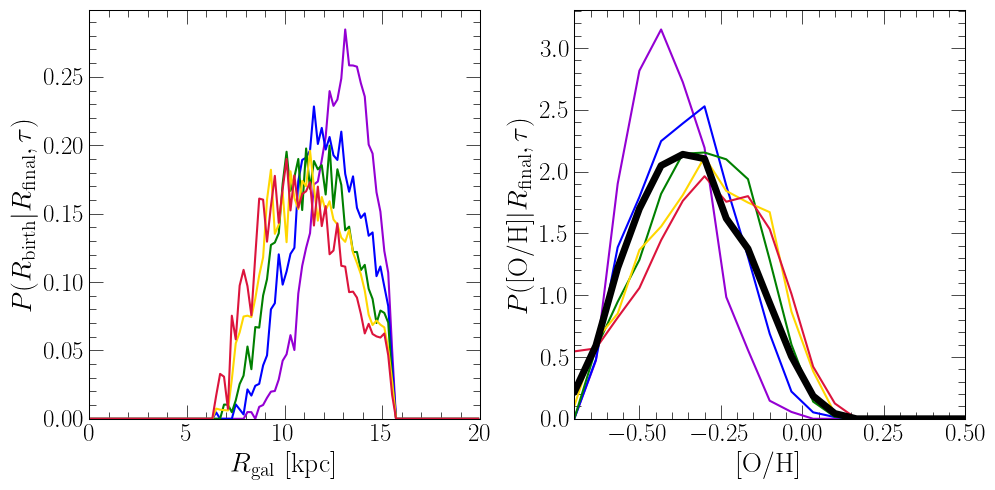

In [38]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax1.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax1.set_ylabel(r"$P(R_\text{birth} | R_\text{final}, \tau)$")
ax1.set_xlim([0, 20])
ax2 = fig.add_subplot(122)
ax2.set_xlabel(r"[O/H]")
ax2.set_ylabel(r"$P(\text{[O/H]} | R_\text{final}, \tau)$")
ax2.set_xlim([-0.7, 0.5])

zone_width = 0.1
rgal_bins = np.linspace(0, 20, 101)
oh_bins = np.linspace(-1, 1, 31)
age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "green", "gold", "crimson"]

sub = stars.filter("zone_final", ">=", 130).filter("zone_final", "<=", 149)
for i in range(len(age_bins) - 1):
    subsub = sub.filter("age", ">=", age_bins[i]).filter("age", "<=", age_bins[i + 1])
    subsub["rbirth"] = [zone_width * (zone + 0.5) for zone in subsub["zone_origin"]]
    rbirth_dist, _ = np.histogram(subsub["rbirth"], bins = rgal_bins, weights = subsub["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(rgal_bins[:-1], rgal_bins[1:])]
    ax1.plot(xvals, rbirth_dist, c = named_colors()[colors[i]])
    oh_dist, _ = np.histogram(subsub["[o/h]"], bins = oh_bins, weights = subsub["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(oh_bins[:-1], oh_bins[1:])]
    ax2.plot(xvals, oh_dist, c = named_colors()[colors[i]])
oh_dist, _ = np.histogram(sub["[o/h]"], bins = oh_bins, weights = sub["mass"], density = True)
xvals = [(a + b) / 2 for a, b in zip(oh_bins[:-1], oh_bins[1:])]
ax2.plot(xvals, oh_dist, c = named_colors()["black"], linewidth = 5)

ax1.set_ylim([0, ax1.get_ylim()[1]])
ax2.set_ylim([0, ax2.get_ylim()[1]])
plt.tight_layout()
plt.show()